In [1]:
import time

import tensorflow as tf
import numpy as np

import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import custom_vgg19

In [2]:
def load_image_as_batch_with_optional_resize(path, newH=None, newW=None):
    img = skimage.io.imread(path)
    img = img / 255.0
    
    oldH, oldW = img.shape[0], img.shape[1] # assume h,w is shape[0] and [1] respectively
    if newH != None or newW != None:
        if newW is None:
            newW = int(oldW * float(newH) / oldH)
        elif newH is None:
            newH = int(oldH * float(newW) / oldW)
        img = skimage.transform.resize(img, (newH, newW))
    
    # delete the Alpha channel if the image is RGBA to make sure # channel is correct
    if img.shape[2]==4:
        img = img[:,:,0:3]
        
    # add another dimension to make it a batch , bacause our vgg19 def takes a batch
    img = img.reshape((1,)+img.shape)
    return img

(1, 454, 500, 3)
(1, 480, 640, 3)


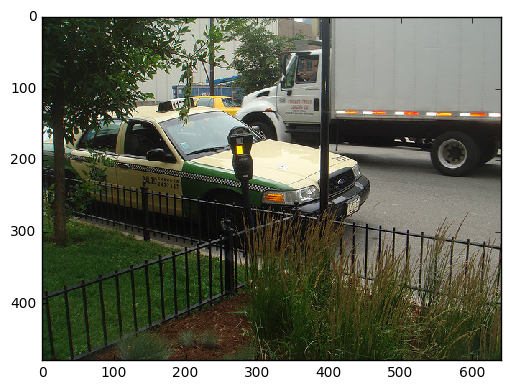

In [3]:
CONTENT_LAYER = 'conv3_2'
STYLE_LAYERS = ('conv1_1', 'conv2_1', 'conv3_1', 'conv4_1')

class ARG:pass
arg = ARG()
arg.gen_img_height=500

styleimg = load_image_as_batch_with_optional_resize('./styles/unknown.jpg')
print(styleimg.shape)
# contentimg = load_image_as_batch_with_optional_resize('./brad_pitt.jpg', newH=arg.gen_img_height)
contentimg = load_image_as_batch_with_optional_resize('contents/smalltestset/COCO_test2014_000000000001.jpg')
print(contentimg.shape)

arg.gen_img_width = contentimg.shape[1] # computed from aspect ratio of content_img
# show image
skimage.io.imshow(contentimg[0])
plt.show()

In [4]:
sess=tf.Session()
img_pl = tf.placeholder(tf.float32)
vgg19factory = custom_vgg19.Vgg19Factory()
vgg19 = vgg19factory.build(img_pl)

print(styleimg.shape)
conv31feat = sess.run(vgg19.conv3_1, feed_dict={img_pl:styleimg})
print(conv31feat.shape)

/work/04006/zhuode93/maverick/dlproj2/trainable-neural-style/tensorflow_vgg/vgg19.npy
npy file loaded
(1, 454, 500, 3)
(1, 114, 125, 256)


In [5]:
def gram_matrix(feat_map):
    assert isinstance(feat_map, tf.Tensor)
    shape = tf.cast(tf.shape(feat_map), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    F = tf.reshape(feat_map, [-1, tf.cast(ch,tf.int32)])
    
    # TODO: if m<n, compute feat_map*feat_map, else compute feat_map'*feat_map 
    gram = tf.matmul(F, F, transpose_a=True) / h / w / ch # not sure why  we have"/ ch". if not, the style_loss is too big
    return gram

def compute_style_loss(gram_of_feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map2), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    G1, G2 = gram_of_feat_map1, gram_matrix(feat_map2)
    style_loss = tf.nn.l2_loss((G1-G2))/ (ch**2) # ch^2 is #element in G1, G2
    return style_loss

def compute_content_loss(feat_map1, feat_map2):
    shape = tf.cast(tf.shape(feat_map1), tf.float32)
    _, h, w, ch = shape[0], shape[1], shape[2], shape[3]
    
    content_loss = tf.nn.l2_loss(feat_map1-feat_map2)/h/w/ch
    return content_loss

In [6]:
batch_shape = contentimg.shape
img_gen = tf.Variable(tf.truncated_normal(contentimg.shape,  mean=0.5, stddev=0.1))
vgg19_pred= vgg19factory.build(img_gen)

In [7]:

# precompute content/style image's stuffs
style_layers_target = [getattr(vgg19, l) for l in STYLE_LAYERS]
content_layer_target = getattr(vgg19, CONTENT_LAYER)
styleimg_grams_np = [sess.run(gram_matrix(l), feed_dict={img_pl:styleimg}) for l in style_layers_target]
contentimg_feat_map_np = sess.run(content_layer_target, feed_dict={img_pl:contentimg})
styleimg_grams = [tf.constant(g, dtype=tf.float32) for g in styleimg_grams_np]
contentimg_feat_map = tf.constant(contentimg_feat_map_np, dtype=tf.float32)

style_layers_pred = [getattr(vgg19_pred, name) for name in STYLE_LAYERS]
content_layer_pred = getattr(vgg19_pred, CONTENT_LAYER)

In [8]:
sess.run(img_gen.initializer)

style_losses = [compute_style_loss(src, dst) for (src,dst) in zip(styleimg_grams,style_layers_pred)]
style_loss_np = sess.run(style_losses)
print 'initial style loss: ' + str(style_loss_np)

content_loss = compute_content_loss(contentimg_feat_map, content_layer_pred)
[content_loss_np] =sess.run([content_loss])
print('initial content loss = %f' % content_loss_np)

# total variation denoising
bsize, h , w, ch = batch_shape
y_tv = tf.nn.l2_loss(img_gen[:,1:,:,:] - img_gen[:,:h-1,:,:])
x_tv = tf.nn.l2_loss(img_gen[:,:,1:,:] - img_gen[:,:,:w-1,:])
tv_loss = (x_tv + y_tv)/(bsize*h*w*ch)
[tv_loss_np] =sess.run([tv_loss])
print('initial TV loss = %f' % tv_loss_np)

total_loss =  10 * reduce(tf.add, style_losses) + 1.5 * content_loss + 100000 * tv_loss
[total_loss_np] = sess.run([total_loss])
print('initial total loss = %f' % total_loss_np)

initial style loss: [93.01564, 2588.0732, 278.92679, 7852.23]
initial content loss = 8288.672852
initial TV loss = 0.015448
initial total loss = 122100.289062


In [9]:
temp = set(tf.all_variables())
train_op = tf.train.AdamOptimizer(0.02).minimize(total_loss)
#I honestly don't know how else to initialize ADAM in TensorFlow.
sess.run(tf.initialize_variables(set(tf.all_variables()) - temp))

# start optimization
iter = 0
MAX_ITER = 200

while iter < MAX_ITER:
    sess.run(train_op)
    iter += 1
    if iter % 10 == 0:
        print(sess.run([total_loss]+style_losses+ [content_loss, tv_loss]))

[57243.156, 106.2355, 1084.3867, 179.46893, 2653.1721, 10205.189, 0.017027399]
[40019.617, 90.467155, 854.69678, 101.35996, 1384.0975, 9406.4092, 0.016037883]
[27082.875, 67.890167, 534.56763, 56.709293, 590.43964, 8827.5527, 0.01345481]
[20100.193, 53.58424, 337.276, 35.508827, 319.91251, 7693.2915, 0.010974393]
[16207.288, 46.886906, 251.56772, 27.479074, 229.65565, 6510.6338, 0.0088544292]
[13655.857, 42.491463, 203.9668, 22.973738, 178.86853, 5626.6206, 0.0073292204]
[11807.842, 37.977161, 167.1958, 19.761589, 143.83754, 4996.0239, 0.0062608463]
[10376.948, 33.283279, 136.40244, 17.172678, 117.09451, 4525.2998, 0.0054946942]
[9229.4219, 28.668474, 110.41255, 14.990265, 96.963898, 4150.4717, 0.0049336255]
[8291.7842, 24.338831, 88.62674, 13.268393, 82.241165, 3837.4614, 0.0045084064]
[7513.2163, 20.397665, 70.764824, 12.012682, 71.96817, 3562.7832, 0.0041760807]
[6857.0034, 16.862572, 56.336281, 11.167654, 64.792229, 3316.3171, 0.0039094039]
[6383.4673, 13.873138, 46.021091, 10.5392

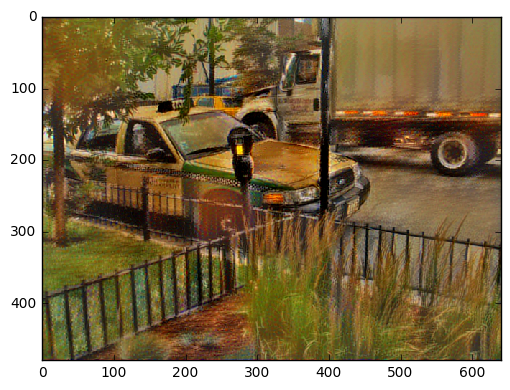

In [10]:

img_gen_clipped = tf.clip_by_value(img_gen, 0,1) #  the range of values in generated image will fall out of [0,1].
            # If you scale it to [0,1] instead of clipping it to [0,1], the image will look "grey"
img_gen_np = np.squeeze(sess.run(img_gen_clipped), 0)
skimage.io.imshow(img_gen_np)
plt.show()